In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import Spectrum_Kernel, Sum_Spectrum_Kernel, WeightedDegree_Kernel

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

In [17]:
kernel_dict = {
    'Spectrum_Kernel': Spectrum_Kernel,
    'WD_Kernel': WeightedDegree_Kernel,
    'Sum_Spectrum_Kernel': Sum_Spectrum_Kernel,
    'Mixed_Spectrum_Kernel': Mixed_Spectrum_Kernel,
    'WD_Kernel_Shift': WD_Shift_Kernel
    
}

log_flag = True

In [3]:
def df_normalize(df, cols = ['Rep1', 'Rep2', 'Rep3', 'Rep4', 'Rep5'], Norm_method = 'mean', Log_flag = True):
    
    df_norm = df.copy(deep=True)
    #df_norm = df
    # take log FC -- possibly provide Gaussian distribution?
    for col_name in cols:
        if Log_flag:
            
            df_norm.loc[df_norm[col_name].notna(), col_name] = np.log(df.loc[df[col_name].notna(), col_name])
            #print(df_norm.loc[df_norm[col_name].notna(), col_name])
        if Norm_method == 'mean':
            # mean normalization
            df_norm[col_name] = (df_norm[col_name] - df_norm[col_name].mean())/df_norm[col_name].std()
            #print(df_norm[col_name])
        elif Norm_method == 'minmax':
            # min-max normalization 
            df_norm[col_name] = (df_norm[col_name] - df_norm[col_name].min())/(df_norm[col_name].max() - df_norm[col_name].min())
        else:
            assert Norm_method == None
        
    df_norm['AVERAGE'] = df_norm.loc[: , "Rep1":"Rep5"].mean(axis=1)
    df_norm['STD'] = df_norm.loc[: , "Rep1":"Rep5"].std(axis=1)
        
    return df_norm

In [18]:
# setting

cv = 5
test_size = 0.2
random_state = 24
embedding = 'label'
eva_on_ave_flag = True # true label is the sample mean instead of individual samples, since the prediction is the posterior mean
eva_metric = mean_squared_error # mean square error returns a more stable optimal hyparameter choice than r2 score

kernel = 'WD_Kernel_Shift'
alpha = 0.5
l = [6]
b = 0.33

weight_flag = False
padding_flag = False
gap_flag = False
plot_format = 'plt'

In [5]:
Path = '../../data/firstRound_4h_normFalse_formatSeq.csv'

df = pd.read_csv(Path)
df.head(20)

,Unnamed: 0,Name,Group,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,AVERAGE,STD
0,0,RBS_1by1_0,reference,TTTAAGAAGGAGATATACAT,AGGAGA,NaN,52.402431,NaN,61.622165,54.151485,56.058694,3.998246
1,1,RBS_1by1_1,bps_noncore,CTTAAGAAGGAGATATACAT,AGGAGA,NaN,40.072951,NaN,42.042854,45.432032,42.515946,2.213263
2,2,RBS_1by1_2,bps_noncore,GTTAAGAAGGAGATATACAT,AGGAGA,NaN,28.831559,NaN,24.487870,24.133637,25.817689,2.136029
3,3,RBS_1by1_3,bps_noncore,ATTAAGAAGGAGATATACAT,AGGAGA,NaN,43.093359,NaN,38.641958,38.049577,39.928298,2.251065
4,4,RBS_1by1_4,bps_noncore,TCTAAGAAGGAGATATACAT,AGGAGA,NaN,45.913214,NaN,44.352931,38.394865,42.887003,3.239660
5,5,RBS_1by1_5,bps_noncore,TGTAAGAAGGAGATATACAT,AGGAGA,NaN,21.973719,NaN,21.205679,21.172242,21.450546,0.370190
6,6,RBS_1by1_6,bps_noncore,TATAAGAAGGAGATATACAT,AGGAGA,NaN,35.402644,NaN,29.738674,31.848506,32.329941,2.337231
7,8,RBS_1by1_8,bps_noncore,TTGAAGAAGGAGATATACAT,AGGAGA,NaN,40.197744,NaN,45.233411,38.655693,41.362283,2.808761
8,9,RBS_1by1_9,bps_noncore,TTAAAGAAGGAGATATACAT,AGGAGA,NaN,27.177739,NaN,24.135049,21.945353,24.419380,2.145554
9,10,RBS_1by1_10,bps_noncore,TTTCAGAAGGAGATATACAT,AGGAGA,NaN,30.926453,NaN,38.223959,31.680388,33.610266,3.276860


In [6]:
# re-normalise labels on new data

df_norm = df_normalize(df, Log_flag=log_flag)

In [7]:
df_norm

,Unnamed: 0,Name,Group,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,AVERAGE,STD
0,0,RBS_1by1_0,reference,TTTAAGAAGGAGATATACAT,AGGAGA,NaN,1.572497,NaN,2.001765,2.026102,1.866788,0.255154
1,1,RBS_1by1_1,bps_noncore,CTTAAGAAGGAGATATACAT,AGGAGA,NaN,1.181122,NaN,1.309597,1.693182,1.394633,0.266411
2,2,RBS_1by1_2,bps_noncore,GTTAAGAAGGAGATATACAT,AGGAGA,NaN,0.700778,NaN,0.331062,0.493596,0.508479,0.185307
3,3,RBS_1by1_3,bps_noncore,ATTAAGAAGGAGATATACAT,AGGAGA,NaN,1.287142,NaN,1.156889,1.356925,1.266986,0.101530
4,4,RBS_1by1_4,bps_noncore,TCTAAGAAGGAGATATACAT,AGGAGA,NaN,1.379619,NaN,1.406433,1.374056,1.386702,0.017312
...,...,...,...,...,...,...,...,...,...,...,...,...
145,173,RBS_RP_54,prob random,TTTAAGATAGTCTTATACAT,TAGTCT,1.927534,1.295124,1.925422,NaN,NaN,1.716027,0.364514
146,174,RBS_RP_55,prob random,TTTAAGAAAGTAGTATACAT,AAGTAG,0.783297,0.664661,0.788035,NaN,NaN,0.745331,0.069902
147,175,RBS_RP_57,prob random,TTTAAGACCACGCTATACAT,CCACGC,0.317509,0.117206,0.333891,NaN,NaN,0.256202,0.120653
148,176,RBS_RP_58,prob random,TTTAAGAGTAATGTATACAT,GTAATG,0.291970,-0.066255,0.337961,NaN,NaN,0.187892,0.221295


(array([ 8.,  4., 16., 17., 14., 28., 28., 21., 11.,  3.]),
 array([-2.22735111, -1.80378607, -1.38022104, -0.956656  , -0.53309097,
        -0.10952594,  0.3140391 ,  0.73760413,  1.16116916,  1.5847342 ,
         2.00829923]),
 <a list of 10 Patch objects>)

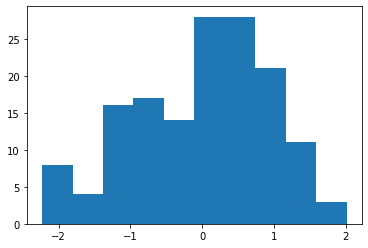

In [8]:
plt.hist(df_norm['AVERAGE'])

(array([31., 20., 34., 15., 21., 17.,  2.,  6.,  2.,  2.]),
 array([ 5.52396791, 10.57744048, 15.63091305, 20.68438561, 25.73785818,
        30.79133075, 35.84480331, 40.89827588, 45.95174845, 51.00522102,
        56.05869358]),
 <a list of 10 Patch objects>)

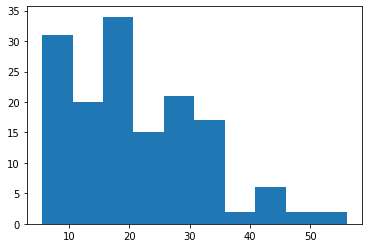

In [9]:
plt.hist(df['AVERAGE'])

## Run over different train test splitting

Train:  0.577204453715902
Test:  0.5986119021586749


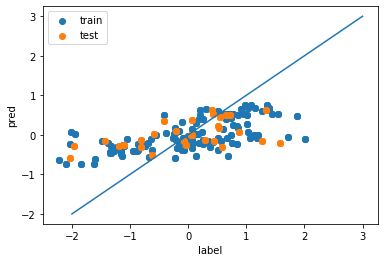

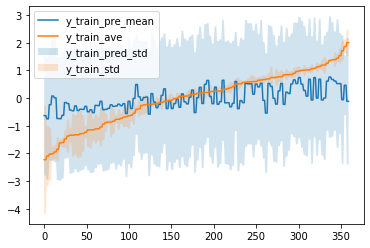

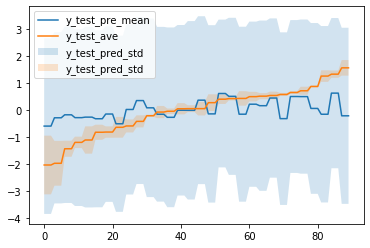

Train:  0.5321818389997062
Test:  0.7210965122323131


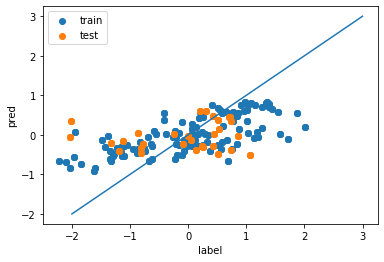

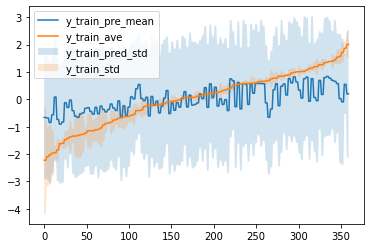

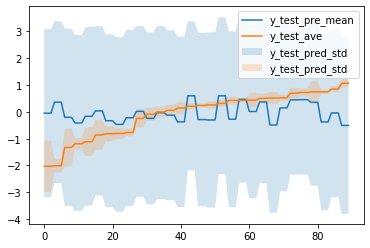

Train:  0.48631487214005376
Test:  1.0950544392527812


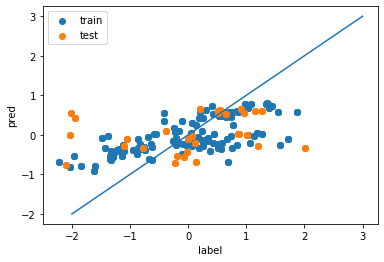

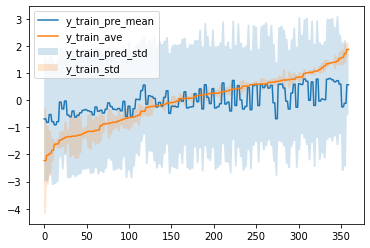

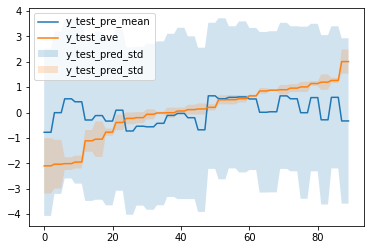

Train:  0.5188086561106766
Test:  0.9507953094992642


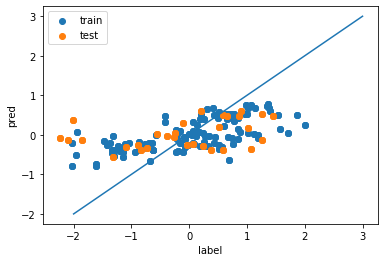

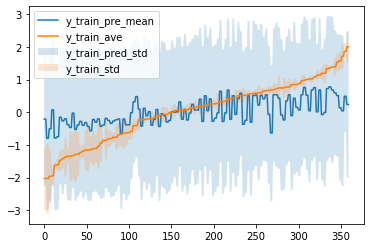

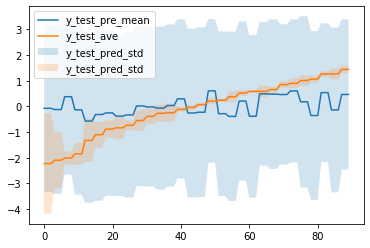

Train:  0.5096427923569159
Test:  0.9000152841789572


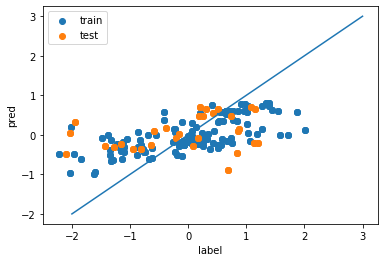

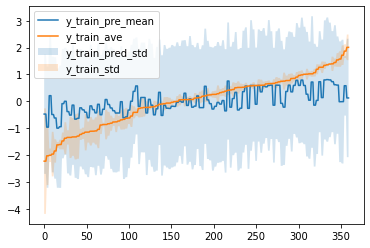

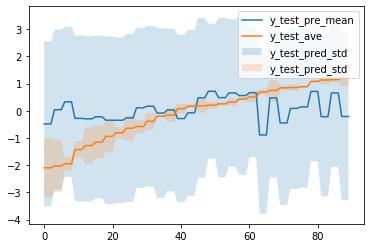

In [19]:
for i in range(5):
    regression(df_norm, random_state=i, test_size=test_size, kernel_name=kernel,alpha=100, embedding='label',
                   eva_metric=eva_metric, eva_on_ave_flag=True, l_list=l, b=b, 
                   weight_flag=False, padding_flag=False, gap_flag=False, plot_format = plot_format)

## Drop sequences with small averages

In [ ]:
df

In [ ]:
#df = df[df['Group'] != 'bps'].reset_index()
#df_sorted = df_norm.sort_values(by = 'AVERAGE', ascending = False).reset_index()
df_big = df[df['AVERAGE'] > 20].reset_index()

In [ ]:
# re-normalise labels on new data

df_big_norm = df_normalize(df_big, Log_flag=log_flag)

In [ ]:
for i in range(5):
    regression(df_big_norm, random_state=i, test_size=test_size, kernel_name=kernel,alpha=alpha, embedding='label',
                   eva_metric=eva_metric, eva_on_ave_flag=True, l_list=l, b=b, 
                   weight_flag=False, padding_flag=False, gap_flag=False, plot_format = plot_format)

## Replicates sequences with high averages

In [ ]:
#df_rep_big = df_big.append(df_big).reset_index()
#df_rep_big_norm = df_normalize(df_rep_big, Log_flag=log_flag)

df_rep_big_norm = df_big_norm.append(df_big_norm).reset_index()

In [ ]:
plt.hist(df_rep_big_norm['AVERAGE'])

In [ ]:
for i in range(5):
    regression(df_rep_big_norm, random_state=i, test_size=test_size, kernel_name=kernel,alpha=alpha, embedding='label',
                   eva_metric=eva_metric, eva_on_ave_flag=True, l_list=l, b=b, 
                   weight_flag=False, padding_flag=False, gap_flag=False, plot_format = plot_format)